# Simple pendulum

In [2]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


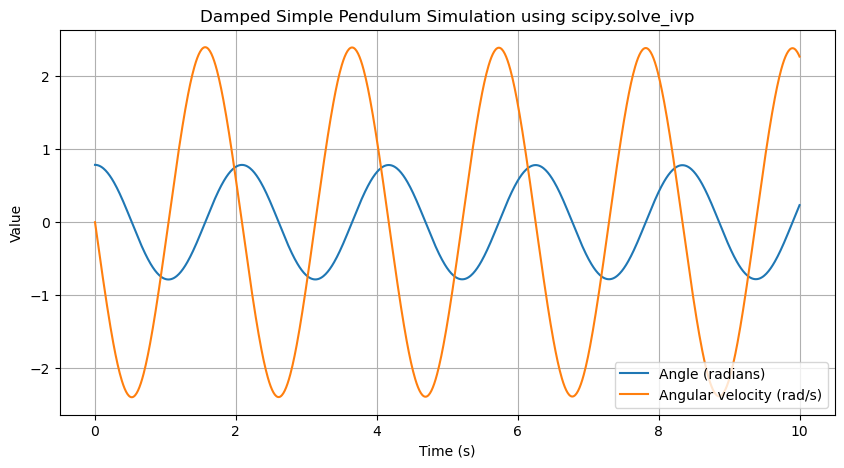

In [3]:


# Function to compute derivatives
def pendulum_rhs(t, y, gamma, L=1):
    """
    Function to compute derivatives for simple pendulum with damping
    
    Parameters:
        t : float
            Time
        y : array_like
            Vector containing [theta, omega], where
            theta is the angle and omega is the angular velocity
        gamma : float
            Damping coefficient
        L : float
            Length of the pendulum
        
    Returns:
        dydt : array_like
            Vector containing [omega, alpha], where
            omega is the angular velocity and alpha is the angular acceleration
    """
    theta, omega = y
    alpha = - (9.81 / L) * np.sin(theta) - gamma * omega
    return [omega, alpha]

# Parameters
theta0 = np.pi / 4  # Initial angle (radians)
omega0 = 0.0        # Initial angular velocity (radians per second)
gamma = 0.0       # Damping coefficient
L = 1.0             # Length of the pendulum (meters)
t_span = (0, 10)    # Time span for the simulation

# Function to integrate the system of ODEs
def integrate_pendulum(t_span, y0, gamma, L):

    sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, y0, method='RK45', t_eval=np.linspace(*t_span, 1000))
    return sol

# Integrate the pendulum system
sol = integrate_pendulum(t_span, [theta0, omega0], gamma, L)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Angle (radians)')
plt.plot(sol.t, sol.y[1], label='Angular velocity (rad/s)')
plt.title('Damped Simple Pendulum Simulation using scipy.solve_ivp')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

wrong_relation_dict = {}

In [4]:
IC_df = pd.read_csv(os.path.join(path_to_add, "parameters/init_cond_simp_pend.csv"))
# IC_df = IC_df.iloc[[0,3]]
params_df = pd.read_csv(os.path.join(path_to_add, "parameters/pend_param.csv"))
g = 9.81   # Acceleration due to gravity (m/s^2)

### Synthesizing data from different ICs

In [5]:
L = 10
# y_shift = 0.9 * L
# y_shift = 0
noise_perc = 0
wrong_relation_dict[noise_perc] = []

num_time_points = 10000
# Time span
t_span = (0.0, 10)  # from 0 to 10 seconds
#Valuation points
t_eval_ = np.linspace(t_span[0], t_span[1], num_time_points)
data_matrix_df_list = []


for param_index in params_df.index:
    params = params_df.loc[param_index]
    # Define parameters
    m_c = params['m_c']  # Mass of the cart (kg)
    m_p = params['m_p']  # Mass of the pendulum (kg)
    l = params['l']    # Length of the pendulum (m)
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        y0 = IC.values
                # Parameters
        theta0 = IC["theta"]  # Initial angle (radians)
        omega0 = IC["omega"]        # Initial angular velocity (radians per second)
        gamma = 0.1         # Damping coefficient
        # Solve the ODEs
        # sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], method='RK45', t_eval=t_eval_)
        sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], t_eval=t_eval_, rtol=1e-12)
        
        sol_df = pd.DataFrame(sol.y.T, columns=["theta", "omega"])
        sol_df["x"] = L*np.sin(sol_df["theta"])
        sol_df["y"] = -L*np.cos(sol_df["theta"])
        sol_df["t"] = t_eval_
        data_matrix_df_list.append(sol_df[["t", "x", "y","theta", "omega"]])
        # data_matrix_df_list.append(sol_df[["t", "x", "y"]])

        # if IC_index == 0:
        #     # Plot the results
        #     plt.figure(figsize=(10, 6))
        #     plt.plot(sol.t, sol.y[0], label='Cart Position (x)')
        #     plt.plot(sol.t, sol.y[2], label='Pendulum Angle (theta)')
        #     plt.xlabel('Time (s)')
        #     plt.ylabel('Position (m) / Angle (rad)')
        #     plt.title('Upright Pendulum on Moving Cart')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.show()

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
print("# data points per IC: {}".format(data_matrix_df.shape[0]/len(IC_df)))


# Adding noise to time-series
sys.path.append(os.path.join(path_to_add, "daeFinder"))

data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["t"]
    np.random.seed(1)
    noise_arr = np.random.normal(size=data_matrix_.shape)
    noisy_data_df = data_matrix_ + (noise_perc/100)*(abs(data_matrix_))*noise_arr
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)

    noisy_data_df["t"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df


## Plotting noisy times-series
# plt.plot(data_matrix_df_list[3]["t"], data_matrix_df_list[3]["x"], data_matrix_df_list[3]["t"], data_matrix_df_list[3]["y"])


# data points per IC: 10000.0


### Smoothing data and finding derivatives

In [37]:
from scipy import interpolate
import itertools

def der_label(feature, der=1):
    if der == 0:
        return feature
    elif der == 1:
        return "d({}) /dt".format(feature)
    else:
        return "d^{}({}) /dt^{}".format(der, feature, der)

from scipy.signal import savgol_filter 
    
def smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="spline",
                s_param_=None,
                noise_perc=0,
                derr_order=1,
                eval_points=[],
                num_time_points=0,
                polyorder=2,
                window_smooth=None
                ):
    """
    :param data_matrix: Data matrix to smoothen. nxp data frame structure is assumed where n is the number of
                        data points and p is the number of features (predictors).
    :param domain_var: Domain variable with respect to which the data needs to be smoothened. Default is assumed to be
                        "t" (time).
    :param smooth_method: Numerical method used for smoothening.
    :param s_param: smoothening parameter.
    :param noise_perc: optional estimate of noise to signal ratio %
    :param derr_order: Number of derivatives need to be calculated, wrt the domain variable, after smoothening the data.
    :param eval_points: option list of points at which the smoothened data and derivatives will be evaluated for output
    :return: pd.DataFrame of size len(eval_points) x k where k is the number of features and their derivatives.
    """
    assert domain_var in data_matrix, "domain variable not found in the data matrix"
    assert len(data_matrix)>3, "At least 3 data points required for smoothening"
    s_param = deepcopy(s_param_)
    data_t = data_matrix[domain_var]
    if num_time_points == 0:
        num_time_points = len(data_matrix)
    if len(eval_points) == 0:
        eval_points = np.linspace(data_t.iloc[0], data_t.iloc[-1], num_time_points)
    t_eval_new = eval_points

    data_matrix_ = data_matrix.drop(domain_var, axis=1)
    data_matrix_std = data_matrix_.std()


    if smooth_method == "spline":
        data_matrix_smooth = pd.DataFrame(t_eval_new, columns=[domain_var])
        if s_param:
            s_param_list = [s_param for feature in data_matrix_]
        else:
            s_param_list = [num_time_points * (0.01 * noise_perc * data_matrix_std[feature]) ** 2 for
                            feature in data_matrix_]
        smoothened_values_list = [np.hstack([interpolate.splev(t_eval_new, interpolate.splrep(data_t,
                                                                                              data_matrix_[feature],
                                                                                              s=s_param_val), der=der_ind) [:, None]
                                             for der_ind in range(derr_order + 1)])
                                  for feature, s_param_val in zip(data_matrix_, s_param_list)]
        smoothened_values = np.hstack(smoothened_values_list)
        column_label_list = [[der_label(feature, der_ind) for der_ind in range(derr_order + 1)]
                             for feature in data_matrix_]
        column_label_list = list(itertools.chain.from_iterable(column_label_list))
        smoothened_df = pd.DataFrame(smoothened_values, columns=column_label_list)
        data_matrix_smooth = pd.concat([data_matrix_smooth, smoothened_df], axis=1)
        return data_matrix_smooth

    elif smooth_method == "SG": #Savitzky-Golay filler for smooth derivatives
        if not window_smooth:
            window_size = len(data_t)//15
        else:
            window_size = len(data_t)//window_smooth
        assert polyorder<window_size, "Polynomial degreee for interpolation must be less than window length"
        data_matrix_smooth = pd.DataFrame(data_t, columns=[domain_var])
        delta_t = data_t[1] - data_t[0] #Spacing of data (assumed to be uniform)

        smoothened_values_list = [np.column_stack([savgol_filter(data_matrix_[feature], window_length=window_size, polyorder=polyorder,
                            deriv=der_ind, delta=delta_t)
                                    for der_ind in range(derr_order + 1)])
                                    for feature in data_matrix_]
        smoothened_values = np.column_stack(smoothened_values_list)
        column_label_list = [[der_label(feature, der_ind) for der_ind in range(derr_order + 1)]
                                for feature in data_matrix_]
        column_label_list = list(itertools.chain.from_iterable(column_label_list))
        smoothened_df = pd.DataFrame(smoothened_values, columns=column_label_list)
        data_matrix_smooth = pd.concat([data_matrix_smooth, smoothened_df], axis=1)
        return data_matrix_smooth
    else:
        raise "Smoothening type not supported"

In [8]:


data_amplify_fact = 1
num_smoothed_points = num_time_points*data_amplify_fact

t_eval_new = np.linspace(data_matrix_df_list[0]["t"].iloc[0], data_matrix_df_list[0]["t"].iloc[-1], num_smoothed_points)

#Calling the smoothening function
# data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=1, noise_perc=noise_perc, s_param_=s_param, eval_points=t_eval_new) for data_matrix in data_matrix_df_list]
data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=noise_perc,
                derr_order=2,
                polyorder=2,
                window_smooth=None)
    for data_matrix in data_matrix_df_list]


if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_smooth = data_matrix_df_smooth_appended[["x","y", "d(x) /dt", "d(y) /dt"]]
data_matrix_df_smooth["x"] = data_matrix_df["x"]
data_matrix_df_smooth["y"] = data_matrix_df["y"]
# data_matrix_df_smooth = data_matrix_df_smooth.iloc[5:-5]

# Removing big bumps in the time series due to noise
new_df = deepcopy(data_matrix_df_smooth)
new_df["energy"] = 0.5*((new_df["d(x) /dt"])**2 + (new_df["d(y) /dt"])**2) +  9.81*new_df["y"]
data_matrix_df_smooth = data_matrix_df_smooth[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]
data_matrix_df_smooth = data_matrix_df_smooth.rename(columns= dict(zip(data_matrix_df_smooth, ['x', 'y', 'x_dot', 'y_dot'])))
print("length of the filtered time-series after removing bumps in dx/dt: {}".format(len(data_matrix_df_smooth)//len(IC_df)))


data_matrix_second_der_df = data_matrix_df_smooth_appended[['d^2(x) /dt^2', 'd^2(y) /dt^2']][abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]

# #Plotting smoothened splines

# ind = 1
# feature_ = "y"

# plt.figure()
# # plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
# #         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

# plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
#          data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
# plt.legend(['Noisy', 'Cubic Spline', 'True'])
# # plt.axis([-0.05, 6.33, -1.05, 1.05])
# plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
# plt.show()

# data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

length of the filtered time-series after removing bumps in dx/dt: 3726


/var/folders/1h/sr7kc8_d5pddvym2zw5gv28r0000gn/T/ipykernel_28953/1724572951.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matrix_df_smooth["x"] = data_matrix_df["x"]
/var/folders/1h/sr7kc8_d5pddvym2zw5gv28r0000gn/T/ipykernel_28953/1724572951.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matrix_df_smooth["y"] = data_matrix_df["y"]


In [9]:
data_matrix_df_smooth_appended.columns

Index(['t', 'x', 'd(x) /dt', 'd^2(x) /dt^2', 'y', 'd(y) /dt', 'd^2(y) /dt^2',
       'theta', 'd(theta) /dt', 'd^2(theta) /dt^2', 'omega', 'd(omega) /dt',
       'd^2(omega) /dt^2'],
      dtype='object')

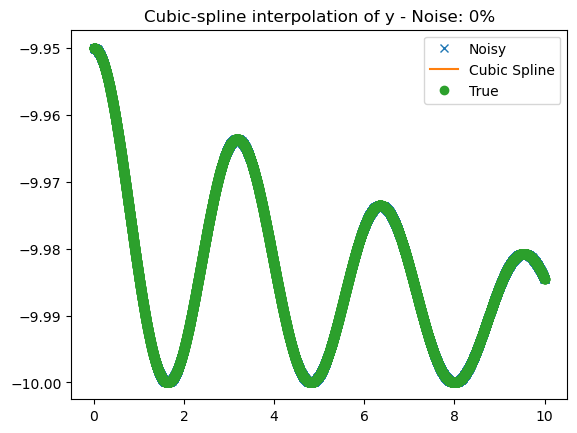

In [10]:
ind = 0
feature_ = "y"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
         data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

In [11]:
new_df = deepcopy(data_matrix_df_smooth)
new_df["energy"] = 0.5*((new_df["x_dot"])**2 + (new_df["y_dot"])**2) +  9.81*new_df["y"]

new_df["dx/dt_exact"] = -new_df['y']*data_matrix_df['omega']
new_df["dy/dt_exact"] = new_df['x']*data_matrix_df['omega']

new_df["energy_exact"] = 0.5*((new_df["dx/dt_exact"])**2 + (new_df["dy/dt_exact"])**2) +  9.81*data_matrix_df["y"]
# new_df_2 = new_df[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]

feature = "y"
# plt.plot(data_matrix_df["t"][:num_time_points], data_matrix_df_smooth["{}_dot".format(feature)][:num_time_points] , label="smoothened {}_dot".format(feature))
# plt.plot(data_matrix_df["t"][:num_time_points], new_df["d{}/dt_exact".format(feature)][:num_time_points] ,label="d{}/dt_exact".format(feature))
# plt.legend()


<Axes: >

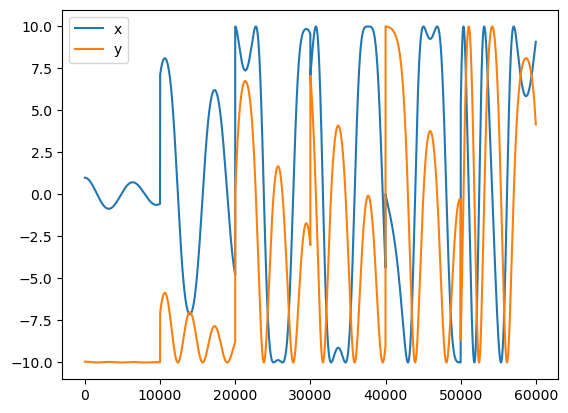

In [12]:
data_matrix_df[["x","y"]].plot()

In [13]:
# from scipy.signal import savgol_filter

# data_matrix = data_matrix_df_list[0]
# # # Extract numpy arrays
# # t = df_["t"].to_numpy()
# # x = df_["x"].to_numpy()
# # y = df_["y"].to_numpy()

# # Compute sampling interval assuming uniform time steps
# # dt = df_["t"][1] - df_["t"][0]

# # Choose Savitzky–Golay parameters
# window_length = num_time_points//15   # Must be odd, e.g. 5, 7, 9, ...
# polyorder = 2        # Usually smaller than window_length

# # # First derivative wrt t for x(t)
# # dx_dt = savgol_filter(x, window_length=window_length, polyorder=polyorder,
# #                       deriv=1, delta=dt)

# # # First derivative wrt t for y(t)
# # dy_dt = savgol_filter(y, window_length=window_length, polyorder=polyorder,
# #                       deriv=1, delta=dt)

# # # Put results back into the DataFrame
# # df_["dx/dt"] = savgol_filter(df_["x"], window_length=window_length, polyorder=polyorder,
# #                       deriv=1, delta=dt)
# # df_["dy/dt"] = savgol_filter(df_["y"], window_length=window_length, polyorder=polyorder,
# #                       deriv=1, delta=dt)

# derr_order = 1
# data_t = data_matrix["t"]
# delta_t = data_matrix["t"][1] - data_matrix["t"][0]
# t_eval_new = data_t

# # t_eval_new = eval_points

# data_matrix_ = data_matrix.drop("t", axis=1)
# data_matrix_smooth = pd.DataFrame(t_eval_new, columns=["t"])



# smoothened_values_list = [np.column_stack([savgol_filter(data_matrix_[feature], window_length=window_length, polyorder=polyorder,
#                        deriv=der_ind, delta=delta_t)
#                             for der_ind in range(derr_order + 1)])
#                             for feature in data_matrix_]
# smoothened_values = np.column_stack(smoothened_values_list)
# column_label_list = [[der_label(feature, der_ind) for der_ind in range(derr_order + 1)]
#                         for feature in data_matrix_]
# column_label_list = list(itertools.chain.from_iterable(column_label_list))
# smoothened_df = pd.DataFrame(smoothened_values, columns=column_label_list)
# data_matrix_smooth = pd.concat([data_matrix_smooth, smoothened_df], axis=1)

## Forming candiate library

In [14]:
len(data_matrix_df_list[0])

10000

In [15]:
data_matrix_df["d(x) /dt"] = -data_matrix_df['y']*data_matrix_df['omega']
data_matrix_df["d(y) /dt"] = data_matrix_df['x']*data_matrix_df['omega']
# data_matrix_df_new = data_matrix_df[["x","y", "d(x) /dt", "d(y) /dt"]]
data_matrix_df_new = data_matrix_df[["x","y", "theta", "omega"]]

# data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['x', 'y', 'x_dot', 'y_dot'])))

In [16]:
poly_degree = 3

poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


Degree of library: 3
# terms in the library: 34
Full candidate library has the following features: Index(['x', 'y', 'theta', 'omega', 'x^2', 'x y', 'x theta', 'x omega', 'y^2',
       'y theta', 'y omega', 'theta^2', 'theta omega', 'omega^2', 'x^3',
       'x^2 y', 'x^2 theta', 'x^2 omega', 'x y^2', 'x y theta', 'x y omega',
       'x theta^2', 'x theta omega', 'x omega^2', 'y^3', 'y^2 theta',
       'y^2 omega', 'y theta^2', 'y theta omega', 'y omega^2', 'theta^3',
       'theta^2 omega', 'theta omega^2', 'omega^3'],
      dtype='object')


## Finding the remaining algebraic relationships

In [17]:

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df_smooth.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df_smooth.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")




seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.3, coef_threshold= 0.05)
# seq_th_model = sequentialThLin(model_id="LR", alhp coef_threshold= 0.1)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_full, scale_columns= False)

algebraic_model_th.best_models()

Sequential threshold converged in 1 iterations


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.05, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.05, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.05, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.05, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

,x,y,theta,omega,x^2,y^2,y^3,x^3,x^2 theta,y^2 theta,...,x y theta,theta^2,omega^3,omega^2,y omega,y omega^2,x omega^2,x y,x omega,x y omega
y,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,99.99998112,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
theta,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,99.99993733,99.99990706,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
omega,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x^2,0.00000000,0.00000000,0.00000000,0.00000000,NaN,-1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,-0.34779175,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.05194959,0.00000000,0.00000000
x y,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,2.50369772,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.16474856,NaN,0.00000000,0.29487006
x theta,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,-7.82784343,0.50777138,0.00000000,0.00000000,0.00000000,0.00000000,0.12312593,0.20209526,0.00000000,0.00000000
x omega,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,9.14981213,-0.05126154,0.00000000,0.00000000,0.06261716,-0.22071664,1.18489295,1.80788771,NaN,-4.10782485
y^2,0.00000000,0.00000000,0.00000000,0.00000000,-1.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,...,0.34779167,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.05194956,0.00000000,0.00000000
y theta,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,-6.74317563,0.93014410,0.00000000,0.00000000,0.00000000,0.00000000,0.31215762,0.49500253,0.00000000,-0.91036965
y omega,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,3.03748313,0.00000000,-0.27491973,0.10543393,NaN,1.26478681,-0.30212622,-3.15313116,0.22315804,2.64753674


In [18]:
features_to_remove = {x**2}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

In [19]:
data_matrix_df_smooth_appended

,t,x,d(x) /dt,d^2(x) /dt^2,y,d(y) /dt,d^2(y) /dt^2,theta,d(theta) /dt,d^2(theta) /dt^2,omega,d(omega) /dt,d^2(omega) /dt^2
0,0.00000000,0.99917805,-0.01409104,-0.88655405,-9.94978502,-0.00422131,-0.07276279,0.10008636,-0.00144177,-0.08895049,0.00020784,-0.10175900,0.03931740
1,0.00100010,0.99916352,-0.01497768,-0.88655405,-9.94978927,-0.00429408,-0.07276279,0.10008488,-0.00153073,-0.08895049,0.00010609,-0.10171967,0.03931740
2,0.00200020,0.99914809,-0.01586432,-0.88655405,-9.94979360,-0.00436685,-0.07276279,0.10008330,-0.00161969,-0.08895049,0.00000438,-0.10168035,0.03931740
3,0.00300030,0.99913179,-0.01675096,-0.88655405,-9.94979801,-0.00443962,-0.07276279,0.10008164,-0.00170865,-0.08895049,-0.00009729,-0.10164103,0.03931740
4,0.00400040,0.99911459,-0.01763761,-0.88655405,-9.94980248,-0.00451239,-0.07276279,0.10007988,-0.00179761,-0.08895049,-0.00019892,-0.10160171,0.03931740
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9.99599960,9.10041354,4.04985059,1.43393514,4.21757009,-7.31103572,-7.77610087,14.57115918,-0.83130429,-0.71124915,-0.84355749,-0.80458430,-0.28297879
59996,9.99699970,9.10446452,4.05128466,1.43393514,4.21025444,-7.31881260,-7.77610087,14.57032744,-0.83201561,-0.71124915,-0.84436229,-0.80486730,-0.28297879
59997,9.99799980,9.10851692,4.05271874,1.43393514,4.20293100,-7.32658948,-7.77610087,14.56949499,-0.83272693,-0.71124915,-0.84516738,-0.80515031,-0.28297879
59998,9.99899990,9.11257076,4.05415282,1.43393514,4.19559979,-7.33436636,-7.77610087,14.56866182,-0.83343825,-0.71124915,-0.84597275,-0.80543332,-0.28297879


In [20]:
features_to_remove = {x**2}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

<Axes: >

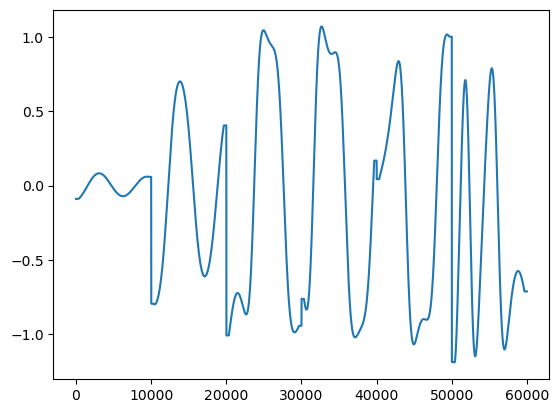

In [21]:
data_matrix_df_smooth_appended['d^2(theta) /dt^2'].plot()

In [22]:
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.05, coef_threshold= 0.01)

seq_th_model.fit(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
seq_th_model.score(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
# data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])
# seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

Sequential threshold converged in 1 iterations


0.999507310125938

In [23]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'x': -0.09692327768993957,
 'y': 0.0,
 'theta': 0.0,
 'omega': -0.10069914010326127,
 'x y': 0.0,
 'x theta': 0.0,
 'x omega': 0.0,
 'y^2': 0.0,
 'y theta': 0.0,
 'y omega': 0.0,
 'theta^2': 0.0,
 'theta omega': 0.0,
 'omega^2': 0.0,
 'x y^2': 0.0,
 'x y theta': 0.0,
 'x y omega': 0.0,
 'x theta^2': 0.0,
 'x theta omega': 0.0,
 'x omega^2': 0.0,
 'y^3': 0.0,
 'y^2 theta': 0.0,
 'y^2 omega': 0.0,
 'y theta^2': 0.0,
 'y theta omega': 0.0,
 'y omega^2': 0.0,
 'theta^3': 0.0,
 'theta^2 omega': 0.0,
 'theta omega^2': 0.0,
 'omega^3': 0.0}

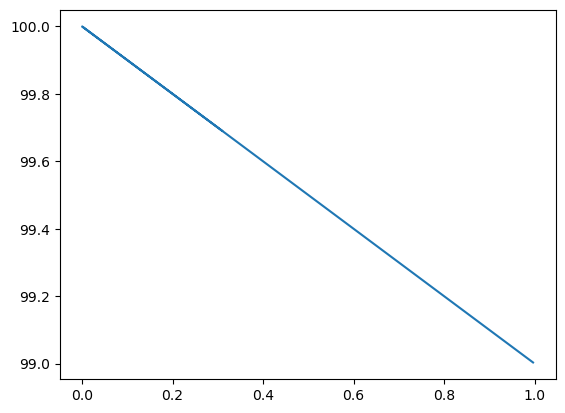

In [24]:
plt.plot(candidate_lib_full[:num_time_points]["x^2"], candidate_lib_full[:num_time_points]["y^2"])

In [25]:
best_models_full = algebraic_model_th.best_models(1)


intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df_smooth.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

NameError: name 'theta' is not defined

In [ ]:

reduced_relationship_features = construct_reduced_fit_list(candidate_lib_full.columns, simplified_eqs=simplified_equations)

reduced_relationship_features
best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)

best_relationship_set = set(best_relationship)

***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 0:  Cannot initialize from 'dict' without generators


In [ ]:
simplified_equations

{'x_dot': {'lhs': 1, 'rhs': 0}}

In [ ]:
best_relationship_set

{'x x_dot', 'y y_dot'}

In [ ]:
true_relationship_dict_2degree = {
    1: {'y^2', 'x^2'},
    2: {'y', 'x_dot^2', 'y_dot^2'}
}

relationship_refinement_2degree = {
    1: {'x^2','x*x_dot'},
    2: {'x_dot^2'}
}

In [ ]:
discovered_true = False
relationship_index = None

for key_,value_ in true_relationship_dict_2degree.items():
    if best_relationship_set == value_:
        discovered_true = True
        relationship_index = key_
if not discovered_true:
    wrong_relation_dict[noise_perc].append(simplified_equations)

features_to_remove =[sympy.sympify(feature) for feature in relationship_refinement_2degree[relationship_index]]

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_smooth,
                                                  candidate_lib_full, get_dropped_feat=True)

seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.3, coef_threshold= 0.05)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)


best_models_full = algebraic_model_th.best_models(1)


intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df_smooth.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

reduced_relationship_features = construct_reduced_fit_list(candidate_lib_full.columns, simplified_eqs=simplified_equations)

reduced_relationship_features
best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)

best_relationship_set = set(best_relationship)

discovered_second_true = False
relationship_index = None

for key_,value_ in true_relationship_dict_2degree.items():
    if best_relationship_set == value_:
        discovered_second_true = True
        relationship_index = key_

if not discovered_second_true:
    wrong_relation_dict[noise_perc].append(simplified_equations)


KeyError: None

In [ ]:
true_relationship_dict_2degree = {
    1: {'y^2', 'x^2'},
    2: {'y', 'x_dot^2', 'y_dot^2'}
}

relationship_refinement_2degree = {
    1: {'x^2','x*x_dot'},
    2: {'x_dot^2'}
}
relationship_index = 1
features_to_remove =[sympy.sympify(feature) for feature in relationship_refinement_2degree[relationship_index]]

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_smooth,
                                                  candidate_lib_full, get_dropped_feat=True)

seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential th

AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x129a3fd10>)

In [ ]:
algebraic_model_th.best_models()

,y_dot,x_dot,y^2 x_dot,x y_dot^2,y_dot^3,x y y_dot,y x_dot,x y_dot,x,y_dot^2,...,y^2 y_dot,y x_dot y_dot,x_dot^3,x_dot^2 y_dot,y y_dot^2,y y_dot,y,y x_dot^2,x y,x_dot^2
x,0.13091809,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-2.48765925,0.00000000,-4.68896704,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000
x_dot,0.00000000,NaN,16.75963149,0.00000000,0.00000000,-11.11652624,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,41.02955076,0.00000000,12.41547468,0.00000000,0.00000000,-5.65144031,0.00000000,0.00000000
x y,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.09229527,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.66690305,0.00000000,0.00000000,NaN,0.00000000
x y_dot,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03767614,NaN,0.00000000,1.05193593,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y^2,0.00000000,0.01702253,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.40481194,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.12767197,0.00000000,0.00000000,0.00000000
y x_dot,0.00000000,0.04159520,8.98601889,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,-9.08284652,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-1.21413281
y y_dot,0.03211246,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,4.01563499,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.24889027,0.00000000
x_dot^2,0.00000000,0.00000000,4.64204052,0.00000000,0.00000000,1.63541469,-0.48947827,0.00000000,0.00000000,-0.39152025,...,0.00000000,0.00000000,0.00000000,-2.79324700,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN
x_dot y_dot,-0.01499745,0.00000000,0.00000000,0.00000000,6.34984978,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,2.59097258,0.00000000,0.00000000,0.00000000,0.00000000,-0.32896641,0.00000000,0.00000000,-0.31218419,-0.11653622


In [ ]:
best_models_full = algebraic_model_th.best_models(1)


intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.001,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df_smooth.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

reduced_relationship_features = construct_reduced_fit_list(candidate_lib_full.columns, simplified_eqs=simplified_equations)

reduced_relationship_features
best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)

best_relationship_set = set(best_relationship)

In [ ]:
best_relationship

['x x_dot', 'y y_dot']

In [ ]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[best_relationship[1:]], y=candidate_lib_full[best_relationship[0]])
model_lin.score(X=candidate_lib_full[best_relationship[1:]], y=candidate_lib_full[best_relationship[0]])

NameError: name 'best_relationship' is not defined

In [ ]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'y y_dot': -1.0000000000000002}

In [ ]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
algebraic_model_1.fit(candidate_lib_full, scale_columns= True)


algebraic_model_1.best_models(5)

,x y,y y_dot,x x_dot,x,x_dot
x,0.00000000,0.00000000,-0.00000000,NaN,0.00000000
y,0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000
x_dot,0.00000000,-0.00000000,0.00000000,0.00000000,NaN
y_dot,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
x^2,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x x_dot,0.00000000,-0.16819653,NaN,-0.00000000,0.00000000
x y_dot,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y^2,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000
y x_dot,-0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
y y_dot,-0.00000000,NaN,-0.25102333,0.00000000,-0.00000000


In [ ]:
features_to_remove = {x**2}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

In [ ]:
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.05, coef_threshold= 0.01)

seq_th_model.fit(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
seq_th_model.score(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])

Sequential threshold converged in 2 iterations


0.9957152953778207

In [ ]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'x': -0.09573934924860023,
 'y': 0.0,
 'theta': 0.0,
 'omega': 0.0,
 'x y': 0.0,
 'x theta': 0.0,
 'x omega': 0.0,
 'y^2': 0.0,
 'y theta': 0.0,
 'y omega': 0.0,
 'theta^2': 0.0,
 'theta omega': 0.0,
 'omega^2': 0.0,
 'x y^2': 0.0,
 'x y theta': 0.0,
 'x y omega': 0.0,
 'x theta^2': 0.0,
 'x theta omega': 0.0,
 'x omega^2': 0.0,
 'y^3': 0.0,
 'y^2 theta': 0.0,
 'y^2 omega': 0.0,
 'y theta^2': 0.0,
 'y theta omega': 0.0,
 'y omega^2': 0.0,
 'theta^3': 0.0,
 'theta^2 omega': 0.0,
 'theta omega^2': 0.0,
 'omega^3': 0.0}

In [ ]:
model_lin.intercept_

3.552713678800501e-15

In [ ]:
data_matrix_df_smooth_appended.columns

Index(['t', 'x', 'd(x) /dt', 'd^2(x) /dt^2', 'y', 'd(y) /dt', 'd^2(y) /dt^2',
       'theta', 'd(theta) /dt', 'd^2(theta) /dt^2', 'omega', 'd(omega) /dt',
       'd^2(omega) /dt^2'],
      dtype='object')

# FInal param est

In [ ]:

model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2"]], y=candidate_lib_full["y"])
model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2"]], y=candidate_lib_full["y"])

0.9918091633484667

In [ ]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.051864451499145,
 'y_dot^2': -0.05106337810338052,
 'y^2': 0.002454517776341498}

In [ ]:

model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["x_dot^2",  "y"]], y=candidate_lib_full["y_dot^2"])
model_lin.score(X=candidate_lib_full[["x_dot^2", "y"]], y=candidate_lib_full["y_dot^2"])

0.9978909782993777

In [ ]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -1.0618209114865043, 'y': -19.52140809693293}

In [ ]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "x_dot y_dot"]], y=candidate_lib_full["y"])
model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "x_dot y_dot"]], y=candidate_lib_full["y"])

0.9999068525947747

In [ ]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.05104276845691093,
 'y_dot^2': -0.0510480714267504,
 'y^2': -6.73522336734388e-05,
 'x_dot y_dot': -2.1570969168485095e-05}

In [ ]:
model_lin.intercept_

AttributeError: 'LinearRegression' object has no attribute 'intercept_'

In [ ]:
# Expected coefficient of x_dot^2 and y_dot^2 
1/(9.8*2) #1/2 * 1/g

0.0510204081632653

In [ ]:
# Expected intercept (coming from energy)
L #L

5.0

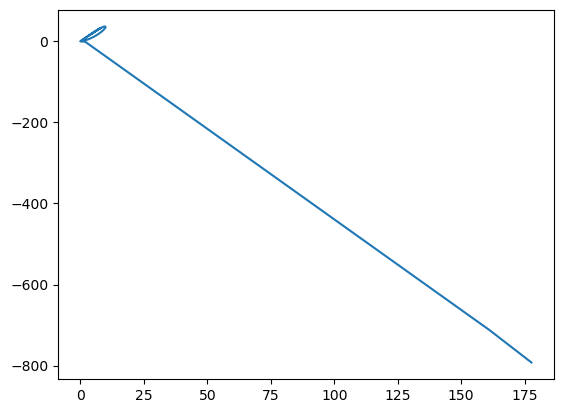

In [ ]:
plt.plot(candidate_lib_full["x_dot^2"][:50], candidate_lib_full["y x_dot^2"][:50])

In [ ]:
plt.plot(candidate_lib_full["y^3"][:100000], candidate_lib_full["x_dot^2"][:100000])

KeyError: 'y^3'

In [ ]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["y^2", "d(y) /dt^2"]], y=candidate_lib_full["x^2"])

### SVD analysis

In [ ]:
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)


pca_2 = decomposition.PCA()
pca_2.fit(candidate_lib_full.drop(["x^2", "x x_dot"],axis=1))

pca_3 = decomposition.PCA()
pca_3.fit(candidate_lib_full.drop(["x^2", "x x_dot", "y"],axis=1))


var_expl_ratio = pca_1.explained_variance_ratio_
theta_dot_sq_rem_expl_ratio = pca_2.explained_variance_ratio_
theta_dot_rem_expl_ratio = pca_3.explained_variance_ratio_


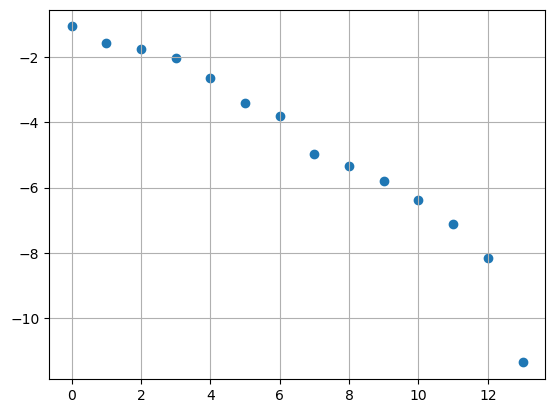

In [ ]:

plt.scatter(np.arange(len(var_expl_ratio)),np.log(var_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

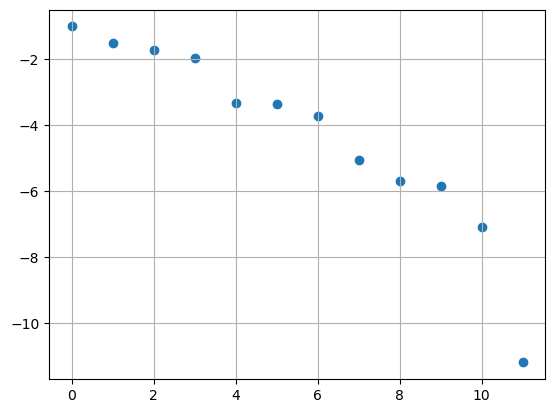

In [ ]:

plt.scatter(np.arange(len(theta_dot_sq_rem_expl_ratio)),np.log(theta_dot_sq_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

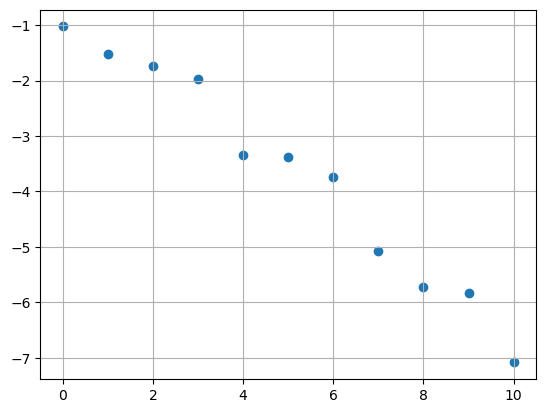

In [ ]:

plt.scatter(np.arange(len(theta_dot_rem_expl_ratio)),np.log(theta_dot_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 37.0 MB/s eta 0:00:0000:0100:01


In [ ]:
import cv2

cap = cv2.VideoCapture("pendulum_1.mp4")

In [ ]:
fgbg = cv2.createBackgroundSubtractorMOG2()

In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for processing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours of detected objects
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        if cv2.contourArea(contour) > 100:  # Filter small noise
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            
            if radius > 5:  # Ensure it's large enough to be the pendulum
                cv2.circle(frame, center, radius, (0, 255, 0), 2)

    cv2.imshow("Pendulum Tracking", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [1]:
import cv2
import numpy as np

def pick_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Left mouse click
        pixel = frame[y, x]
        hsv_pixel = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_BGR2HSV)[0][0]
        print(f"HSV Color at ({x}, {y}): {hsv_pixel}")
ind = 4
video_path = "pendulum_{}.mov".format(ind)
cap = cv2.VideoCapture(video_path)

cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", pick_color)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Frame", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


HSV Color at (1351, 54): [  0   0 252]
HSV Color at (944, 712): [  0   0 122]
HSV Color at (944, 712): [  0   0 122]
HSV Color at (944, 712): [  0   0 204]


In [ ]:
center = (943.5, 711.5)
color = [120, 255, 243]

In [3]:
import cv2
import numpy as np
import pandas as pd

# Define HSV color range for the pendulum bob (Replace with detected values)
lower_color = np.array([120, 255, 243])  # Replace with detected values
upper_color = np.array([120, 255, 243])

for ind in range(2,5):
    # ind =1
    video_path = "pendulum_{}.mov".format(ind)

    cap = cv2.VideoCapture(video_path)

    # Get FPS (frames per second) from video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time interval between frames

    # List to store detected coordinates with time
    positions = []
    frame_count = 0  # To track frame number

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1  # Track frame number
        time = frame_count * frame_time  # Compute time in seconds

        # Convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create a mask for the pendulum bob's color
        mask = cv2.inRange(hsv, lower_color, upper_color)

        # Perform morphological operations
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Find contours from the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Select the largest contour (assumed to be the pendulum bob)
            largest_contour = max(contours, key=cv2.contourArea)

            # Get bounding box around the detected bob
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Calculate center of the bounding box (Pendulum bob's position)
            center_x = x + w // 2
            center_y = y + h // 2

            # Store time and coordinates
            positions.append([time, center_x, center_y])

            # Draw tracking marker
            cv2.circle(frame, (center_x, center_y), 5, (0, 255, 0), -1)
            cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Show the tracking result
        cv2.imshow("Pendulum Tracking", frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Convert positions to a DataFrame and save as CSV
    df = pd.DataFrame(positions, columns=["t", "X", "Y"])
    df.to_csv("pendulum_time_series_{}.csv".format(ind), index=False)

    print("Pendulum position data with time saved to 'pendulum_time_series.csv'")


Pendulum position data with time saved to 'pendulum_time_series.csv'
Pendulum position data with time saved to 'pendulum_time_series.csv'
Pendulum position data with time saved to 'pendulum_time_series.csv'


In [4]:
df_list = []
for ind in range(1, 5):
    file_path = f"pendulum_time_series_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

<Axes: >

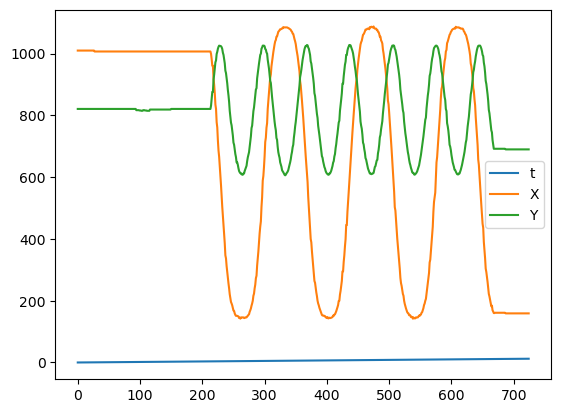

In [25]:
df.plot()

In [81]:
df["x"] = df["X"] - 614
df["y"] = df["Y"] - 555


# HSV Color at (614, 555): [  0   0 117]
# HSV Color at (615, 552): [  0   0 120]

In [82]:
df["x"] = df["x"]/abs(df["y"].max())*10
df["y"] = df["y"]/abs(df["y"].max())*10


<Axes: >

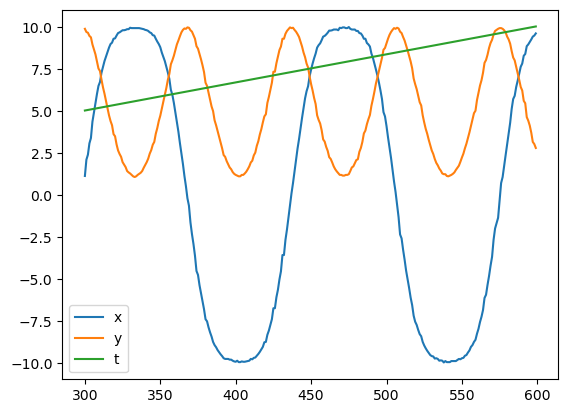

In [83]:
df[["x","y","t"]][300:600].plot()

In [84]:
(df["x"]**2+df["y"]**2).std()

(df["x"]**2+df["y"]**2).mean()

100.19174429162373

<Axes: >

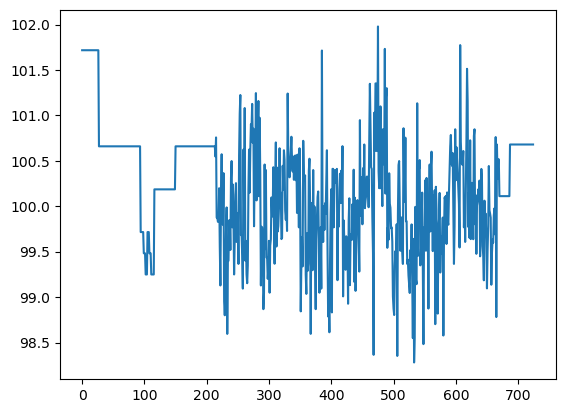

In [85]:
(df["x"]**2+df["y"]**2).plot()

<Axes: >

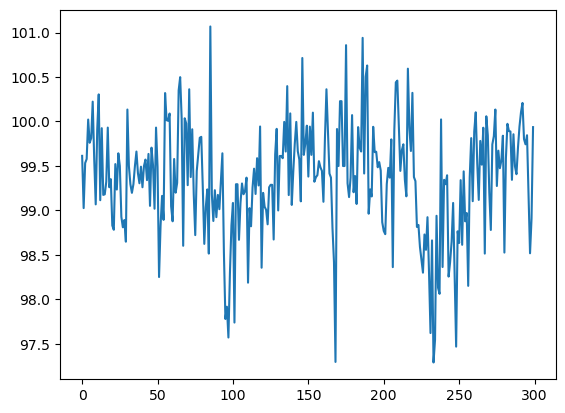

In [86]:
(df_new["x"]**2+df_new["y"]**2).plot()

In [87]:
df_new = df[["x","y","t"]][300:600].reset_index(drop=True)
df_new["theta"] = np.arctan2(df_new["y"], df_new["x"])

In [88]:
df_new

,x,y,t,theta
0,1.141649,9.915433,5.044193,1.456163
1,2.114165,9.725159,5.060951,1.356736
2,2.410148,9.682875,5.077709,1.326845
3,3.086681,9.492600,5.094467,1.256413
4,3.403805,9.408034,5.111225,1.223650
...,...,...,...,...
295,9.133192,4.143763,9.987837,0.425930
296,9.281184,3.720930,10.004595,0.381292
297,9.450317,3.171247,10.021353,0.323763
298,9.513742,3.044397,10.038112,0.309703


In [89]:
df_new = df[["x","y","t"]][300:600].reset_index(drop=True)
df_new["theta"] = np.arctan2(df_new["y"], df_new["x"])
from copy import deepcopy
data_matrix_df_smooth_appended = smooth_data(df_new,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=2,
                derr_order=2,
                polyorder=2,
                window_smooth=None)

In [90]:
data_matrix_df_smooth_appended

,t,x,d(x) /dt,d^2(x) /dt^2,y,d(y) /dt,d^2(y) /dt^2,theta,d(theta) /dt,d^2(theta) /dt^2
0,5.044193,1.115936,43.430993,-110.795415,10.101109,-12.362403,-52.837724,1.459489,-4.311714,5.579766
1,5.060951,1.828200,41.574270,-110.795415,9.886519,-13.247863,-52.837724,1.388016,-4.218208,5.579766
2,5.077709,2.509349,39.717548,-110.795415,9.657091,-14.133324,-52.837724,1.318110,-4.124701,5.579766
3,5.094467,3.159382,37.860825,-110.795415,9.412824,-15.018785,-52.837724,1.249772,-4.031195,5.579766
4,5.111225,3.778301,36.004103,-110.795415,9.153718,-15.904245,-52.837724,1.183000,-3.937688,5.579766
...,...,...,...,...,...,...,...,...,...,...
295,9.987837,9.176782,9.603792,-114.268760,4.170653,-23.572988,-15.154075,0.421371,-2.444506,6.895239
296,10.004595,9.321678,7.688863,-114.268760,3.773486,-23.826941,-15.154075,0.381374,-2.328954,6.895239
297,10.021353,9.434484,5.773934,-114.268760,3.372063,-24.080895,-15.154075,0.343313,-2.213403,6.895239
298,10.038112,9.515199,3.859005,-114.268760,2.966385,-24.334849,-15.154075,0.307189,-2.097852,6.895239


In [91]:
df_new[["x","y"]]

,x,y
0,1.141649,9.915433
1,2.114165,9.725159
2,2.410148,9.682875
3,3.086681,9.492600
4,3.403805,9.408034
...,...,...
295,9.133192,4.143763
296,9.281184,3.720930
297,9.450317,3.171247
298,9.513742,3.044397


In [92]:
# data_matrix_df["d(x) /dt"] = -data_matrix_df['y']*data_matrix_df['omega']
# data_matrix_df["d(y) /dt"] = data_matrix_df['x']*data_matrix_df['omega']
# # data_matrix_df_new = data_matrix_df[["x","y", "d(x) /dt", "d(y) /dt"]]
# data_matrix_df_new = data_matrix_df_smooth_appended[["x","y", "theta", "d(theta) /dt"]]
# data_matrix_df_new = data_matrix_df_smooth_appended[["x","y"]]
data_matrix_df_new = df_new[["x","y"]]



# data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['x', 'y', 'x_dot', 'y_dot'])))

In [93]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))

poly_degree = 3
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder
Degree of library: 3
# terms in the library: 9
Full candidate library has the following features: Index(['x', 'y', 'x^2', 'x y', 'y^2', 'x^3', 'x^2 y', 'x y^2', 'y^3'], dtype='object')


In [102]:
from daeFinder import sequentialThLin
from daeFinder import AlgModelFinder
from daeFinder import remove_paranth_from_feat
# Adding the state variables as scipy symbols
# feat_list = list(data_matrix_df_smooth_appended.columns)
# feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df_smooth_appended.columns))
# exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")




seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
# seq_th_model = sequentialThLin(model_id="LR", alhp coef_threshold= 0.1)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_full, scale_columns= False)

algebraic_model_th.best_models()

Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


,y,y^3,x,x^3,x^2 y,y^2,x^2,x y^2,x y
x,0.000000,0.000000,NaN,100.121154,0.000000,0.000000,0.000000,98.084678,3.788142
x^2,0.000000,4.067808,0.000000,-0.395491,4.351556,-0.994834,NaN,-0.441870,-8.153265
x y,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124222,NaN
y^2,0.000000,4.966453,0.000000,-0.386438,4.631498,NaN,-1.004906,-0.429027,-7.397318
x^3,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,-0.981602,0.000000
x^2 y,0.000000,-0.942711,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.676967
x y^2,0.000000,0.000000,0.000000,-1.004707,0.000000,0.000000,0.000000,NaN,0.000000
y^3,0.000000,NaN,0.000000,0.000000,-1.020031,0.000000,0.000000,0.000000,0.629398
y,NaN,90.258108,0.000000,-0.587530,98.860130,0.000000,0.000000,-0.611742,-70.872991
r2- metric,0.999971,0.999970,0.999968,0.999955,0.999758,0.999715,0.999715,0.999607,0.725945


In [ ]:
candidate_lib_full[]

In [ ]:
features_to_remove = {x**2}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

In [ ]:
data_matrix_df_smooth_appended

,t,x,d(x) /dt,d^2(x) /dt^2,y,d(y) /dt,d^2(y) /dt^2,theta,d(theta) /dt,d^2(theta) /dt^2,omega,d(omega) /dt,d^2(omega) /dt^2
0,0.00000000,0.99917805,-0.01409104,-0.88655405,-9.94978502,-0.00422131,-0.07276279,0.10008636,-0.00144177,-0.08895049,0.00020784,-0.10175900,0.03931740
1,0.00100010,0.99916352,-0.01497768,-0.88655405,-9.94978927,-0.00429408,-0.07276279,0.10008488,-0.00153073,-0.08895049,0.00010609,-0.10171967,0.03931740
2,0.00200020,0.99914809,-0.01586432,-0.88655405,-9.94979360,-0.00436685,-0.07276279,0.10008330,-0.00161969,-0.08895049,0.00000438,-0.10168035,0.03931740
3,0.00300030,0.99913179,-0.01675096,-0.88655405,-9.94979801,-0.00443962,-0.07276279,0.10008164,-0.00170865,-0.08895049,-0.00009729,-0.10164103,0.03931740
4,0.00400040,0.99911459,-0.01763761,-0.88655405,-9.94980248,-0.00451239,-0.07276279,0.10007988,-0.00179761,-0.08895049,-0.00019892,-0.10160171,0.03931740
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9.99599960,9.10041354,4.04985059,1.43393514,4.21757009,-7.31103572,-7.77610087,14.57115918,-0.83130429,-0.71124915,-0.84355749,-0.80458430,-0.28297879
59996,9.99699970,9.10446452,4.05128466,1.43393514,4.21025444,-7.31881260,-7.77610087,14.57032744,-0.83201561,-0.71124915,-0.84436229,-0.80486730,-0.28297879
59997,9.99799980,9.10851692,4.05271874,1.43393514,4.20293100,-7.32658948,-7.77610087,14.56949499,-0.83272693,-0.71124915,-0.84516738,-0.80515031,-0.28297879
59998,9.99899990,9.11257076,4.05415282,1.43393514,4.19559979,-7.33436636,-7.77610087,14.56866182,-0.83343825,-0.71124915,-0.84597275,-0.80543332,-0.28297879


In [ ]:
features_to_remove = {x**2}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

<Axes: >

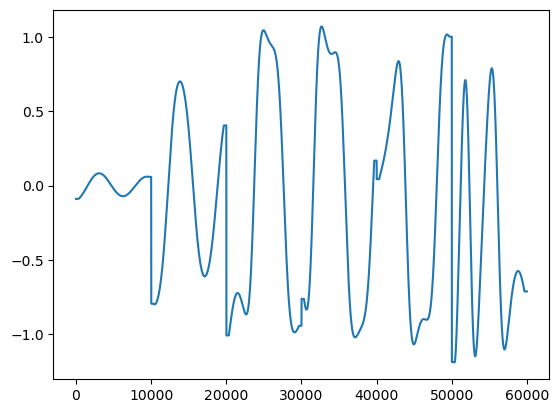

In [ ]:
data_matrix_df_smooth_appended['d^2(theta) /dt^2'].plot()

In [ ]:
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.05, coef_threshold= 0.01)

seq_th_model.fit(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
seq_th_model.score(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
# data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])
# seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

Sequential threshold converged in 1 iterations


0.999507310125938

In [ ]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'x': -0.09692327768993957,
 'y': 0.0,
 'theta': 0.0,
 'omega': -0.10069914010326127,
 'x y': 0.0,
 'x theta': 0.0,
 'x omega': 0.0,
 'y^2': 0.0,
 'y theta': 0.0,
 'y omega': 0.0,
 'theta^2': 0.0,
 'theta omega': 0.0,
 'omega^2': 0.0,
 'x y^2': 0.0,
 'x y theta': 0.0,
 'x y omega': 0.0,
 'x theta^2': 0.0,
 'x theta omega': 0.0,
 'x omega^2': 0.0,
 'y^3': 0.0,
 'y^2 theta': 0.0,
 'y^2 omega': 0.0,
 'y theta^2': 0.0,
 'y theta omega': 0.0,
 'y omega^2': 0.0,
 'theta^3': 0.0,
 'theta^2 omega': 0.0,
 'theta omega^2': 0.0,
 'omega^3': 0.0}

In [ ]:
df_new = df[["x","y","t"]]

data_amplify_fact = 1
num_smoothed_points = num_time_points*data_amplify_fact
data_matrix_df_smooth_appended = smooth_data(df_new,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=noise_perc,
                derr_order=2,
                polyorder=2,
                window_smooth=None)

t_eval_new = np.linspace(data_matrix_df_list[0]["t"].iloc[0], data_matrix_df_list[0]["t"].iloc[-1], num_smoothed_points)

#Calling the smoothening function
# data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=1, noise_perc=noise_perc, s_param_=s_param, eval_points=t_eval_new) for data_matrix in data_matrix_df_list]
data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=noise_perc,
                derr_order=2,
                polyorder=2,
                window_smooth=None)
    for data_matrix in data_matrix_df_list]


if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_smooth = data_matrix_df_smooth_appended[["x","y", "d(x) /dt", "d(y) /dt"]]
data_matrix_df_smooth["x"] = data_matrix_df["x"]
data_matrix_df_smooth["y"] = data_matrix_df["y"]
# data_matrix_df_smooth = data_matrix_df_smooth.iloc[5:-5]

# Removing big bumps in the time series due to noise
new_df = deepcopy(data_matrix_df_smooth)
new_df["energy"] = 0.5*((new_df["d(x) /dt"])**2 + (new_df["d(y) /dt"])**2) +  9.81*new_df["y"]
data_matrix_df_smooth = data_matrix_df_smooth[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]
data_matrix_df_smooth = data_matrix_df_smooth.rename(columns= dict(zip(data_matrix_df_smooth, ['x', 'y', 'x_dot', 'y_dot'])))
print("length of the filtered time-series after removing bumps in dx/dt: {}".format(len(data_matrix_df_smooth)//len(IC_df)))


data_matrix_second_der_df = data_matrix_df_smooth_appended[['d^2(x) /dt^2', 'd^2(y) /dt^2']][abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]

# #Plotting smoothened splines

# ind = 1
# feature_ = "y"

# plt.figure()
# # plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
# #         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

# plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
#          data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
# plt.legend(['Noisy', 'Cubic Spline', 'True'])
# # plt.axis([-0.05, 6.33, -1.05, 1.05])
# plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
# plt.show()

# data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()